In [1]:
import networkx as nx
import stellargraph as sg
import pandas as pd
import numpy as np
import warnings
import tensorflow as tf
import random

from sklearn import preprocessing, model_selection

from tensorflow.keras import layers, Model, optimizers, losses, callbacks

warnings.filterwarnings('ignore')
np.random.seed(0)
tf.random.set_seed(0)

In [2]:
# set edges
edges = pd.read_table('../datasets/cora/cora.cites', header=None)
edges.columns = ['source', 'target'] # should be follow this column name
gx = nx.from_pandas_edgelist(edges) # stellar graph form

# load features
features = pd.read_table('../datasets/cora/cora.content', header=None, index_col=0)
target = features[features.columns[-1]]
features = features.drop(features.columns[-1], axis=1)
col_names = ['w_'+str(i) for i in range(1, 1434)]
features.columns = col_names


# make graph
G = sg.StellarGraph(gx, node_features=features)
nodes = list(G.nodes())
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  default: [2708]
    Features: float32 vector, length 1433
    Edge types: default-default->default

 Edge types:
    default-default->default: [5278]


In [3]:
# random - walk process to find neighbors 
rw = sg.data.BiasedRandomWalk(G)
walks = rw.run(nodes, n=10, length=80, p=0.5, q=1)

In [4]:
# it is optinal to choose embedding startegy
# and the below is introduced by stellargraph
from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, iter=1)


In [5]:
# Visualization

In [6]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
x = (model.wv.vectors)  # numpy.ndarray of size number of nodes times embeddings dimensionality
y = target[[int(node_id) for node_id in node_ids]]

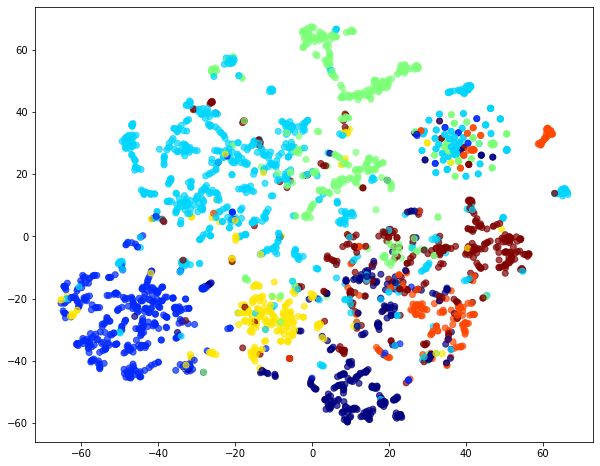

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
tsne_x = tsne.fit_transform(x)

alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(y))}
node_colours = [label_map[target] for target in y]

plt.figure(figsize=(10, 8))
plt.scatter(
    tsne_x[:, 0],
    tsne_x[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)

In [8]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=500)

print('fl-micro:', round(np.mean(model_selection.cross_val_score(lr, x, y, scoring='f1_micro', cv=10)), 3))
print('f1-macro:', round(np.mean(model_selection.cross_val_score(lr, x, y, scoring='f1_macro', cv=10)), 3))


fl-micro: 0.818
f1-macro: 0.808


In [9]:
lbe = preprocessing.LabelBinarizer()
targets = lbe.fit_transform(y)

# choose a random set of training nodes by permuting the labels and taking the first 300.
shuffled_idx = np.random.permutation(targets.shape[0])
train_node_idx = shuffled_idx[:500]
test_node_idx = shuffled_idx[500:]

training_labels = targets.copy()
training_labels[test_node_idx] = 0

d = x.shape[1] // 2

predictions = np.dot(np.exp(np.dot(x[:, :d], x[:, d:].transpose())), training_labels)

np.mean(np.argmax(predictions[test_node_idx], 1) == np.argmax(targets[test_node_idx], 1))


0.23596014492753623